In [1]:
import numpy as np
import cvxpy as cp
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import gamma
import itertools
import time
import mosek
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes


In [2]:
from sympy import symbols, Eq, solve, exp, sqrt, log

# Define the variables
beta, N, tau, q = symbols('beta N tau q', real=True, positive=True)

# Define the equation
equation = Eq(log(beta), q*log((sqrt(N) * tau) / sqrt(q)) - (2 * N * tau**2))

# Solve for tau
tau_solution = solve(equation, tau)
tau_solution

[beta**(1/q)*sqrt(q)*exp(-LambertW(-4*beta**(2/q))/2)/sqrt(N),
 beta**(1/q)*sqrt(q)*exp(-LambertW(4*beta**(2/q))/2)/sqrt(N)]

In [3]:
def plot_regret_analysis(cumulative_regret, regret, theo):
    """Plot regret analysis results with LaTeX formatting and log scales."""
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 22,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.fontsize": 22
    })
    
    # Create figure with 2x2 subplots

    T = len(cumulative_regret)
    t_range = np.arange(1, T+1)

    fig, ax = plt.subplots(1,1, figsize=(9, 4), dpi=300)
    ax.semilogy(t_range, cumulative_regret, 'b-', linewidth=2, label = "actual regret")
    ax.semilogy(t_range, theo, 'r-', linewidth=2, label = "upper bound")
    # axins = zoomed_inset_axes(ax, 6, loc="lower right")
    # axins.set_xlim(3700, 4000)
    # axins.set_ylim(7, 10)
    # axins.plot(t_range, cumulative_regret, 'b-',linewidth=2)
    # axins.grid(True,alpha=0.3)
    # axins.set_xticks(ticks=[])
    # axins.set_yticks(ticks=[])
    #mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")
    ax.set_xlabel(r'Time step $(t)$')
    ax.set_ylabel(r'Regret')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.savefig('regret_analysis_comp2.pdf', bbox_inches='tight', dpi=300)

In [5]:
theoretical = np.zeros(4000)
# theoretical[0] = 0.28*(1/np.sqrt(10))
# for t in range(1,4000):            
#   theoretical[t] = theoretical[t-1] + 0.28*(1/np.sqrt(t+10))
theoretical[0] = 0
for t in range(1,4000):            
  theoretical[t] = theoretical[t-1] + 1.15/(t+1)

In [6]:
dists = np.load("min_dist.npy")

In [7]:
dists

array([0.314636  , 0.59073109, 0.25101533, ..., 0.59539544, 0.45276366,
       0.70712269])

In [8]:
avg = [np.mean(dists[:t+10]) for t in range(4000)]
avg_mean = [np.mean(avg[:t]) for t in range(1,4001)]

In [9]:
cum_regret = np.load("regret2.npy")
inst_regret = np.concatenate([[cum_regret[0]], np.diff(cum_regret)])
avg_regret = [np.mean(inst_regret[:t]) for t in range(1,4001)]

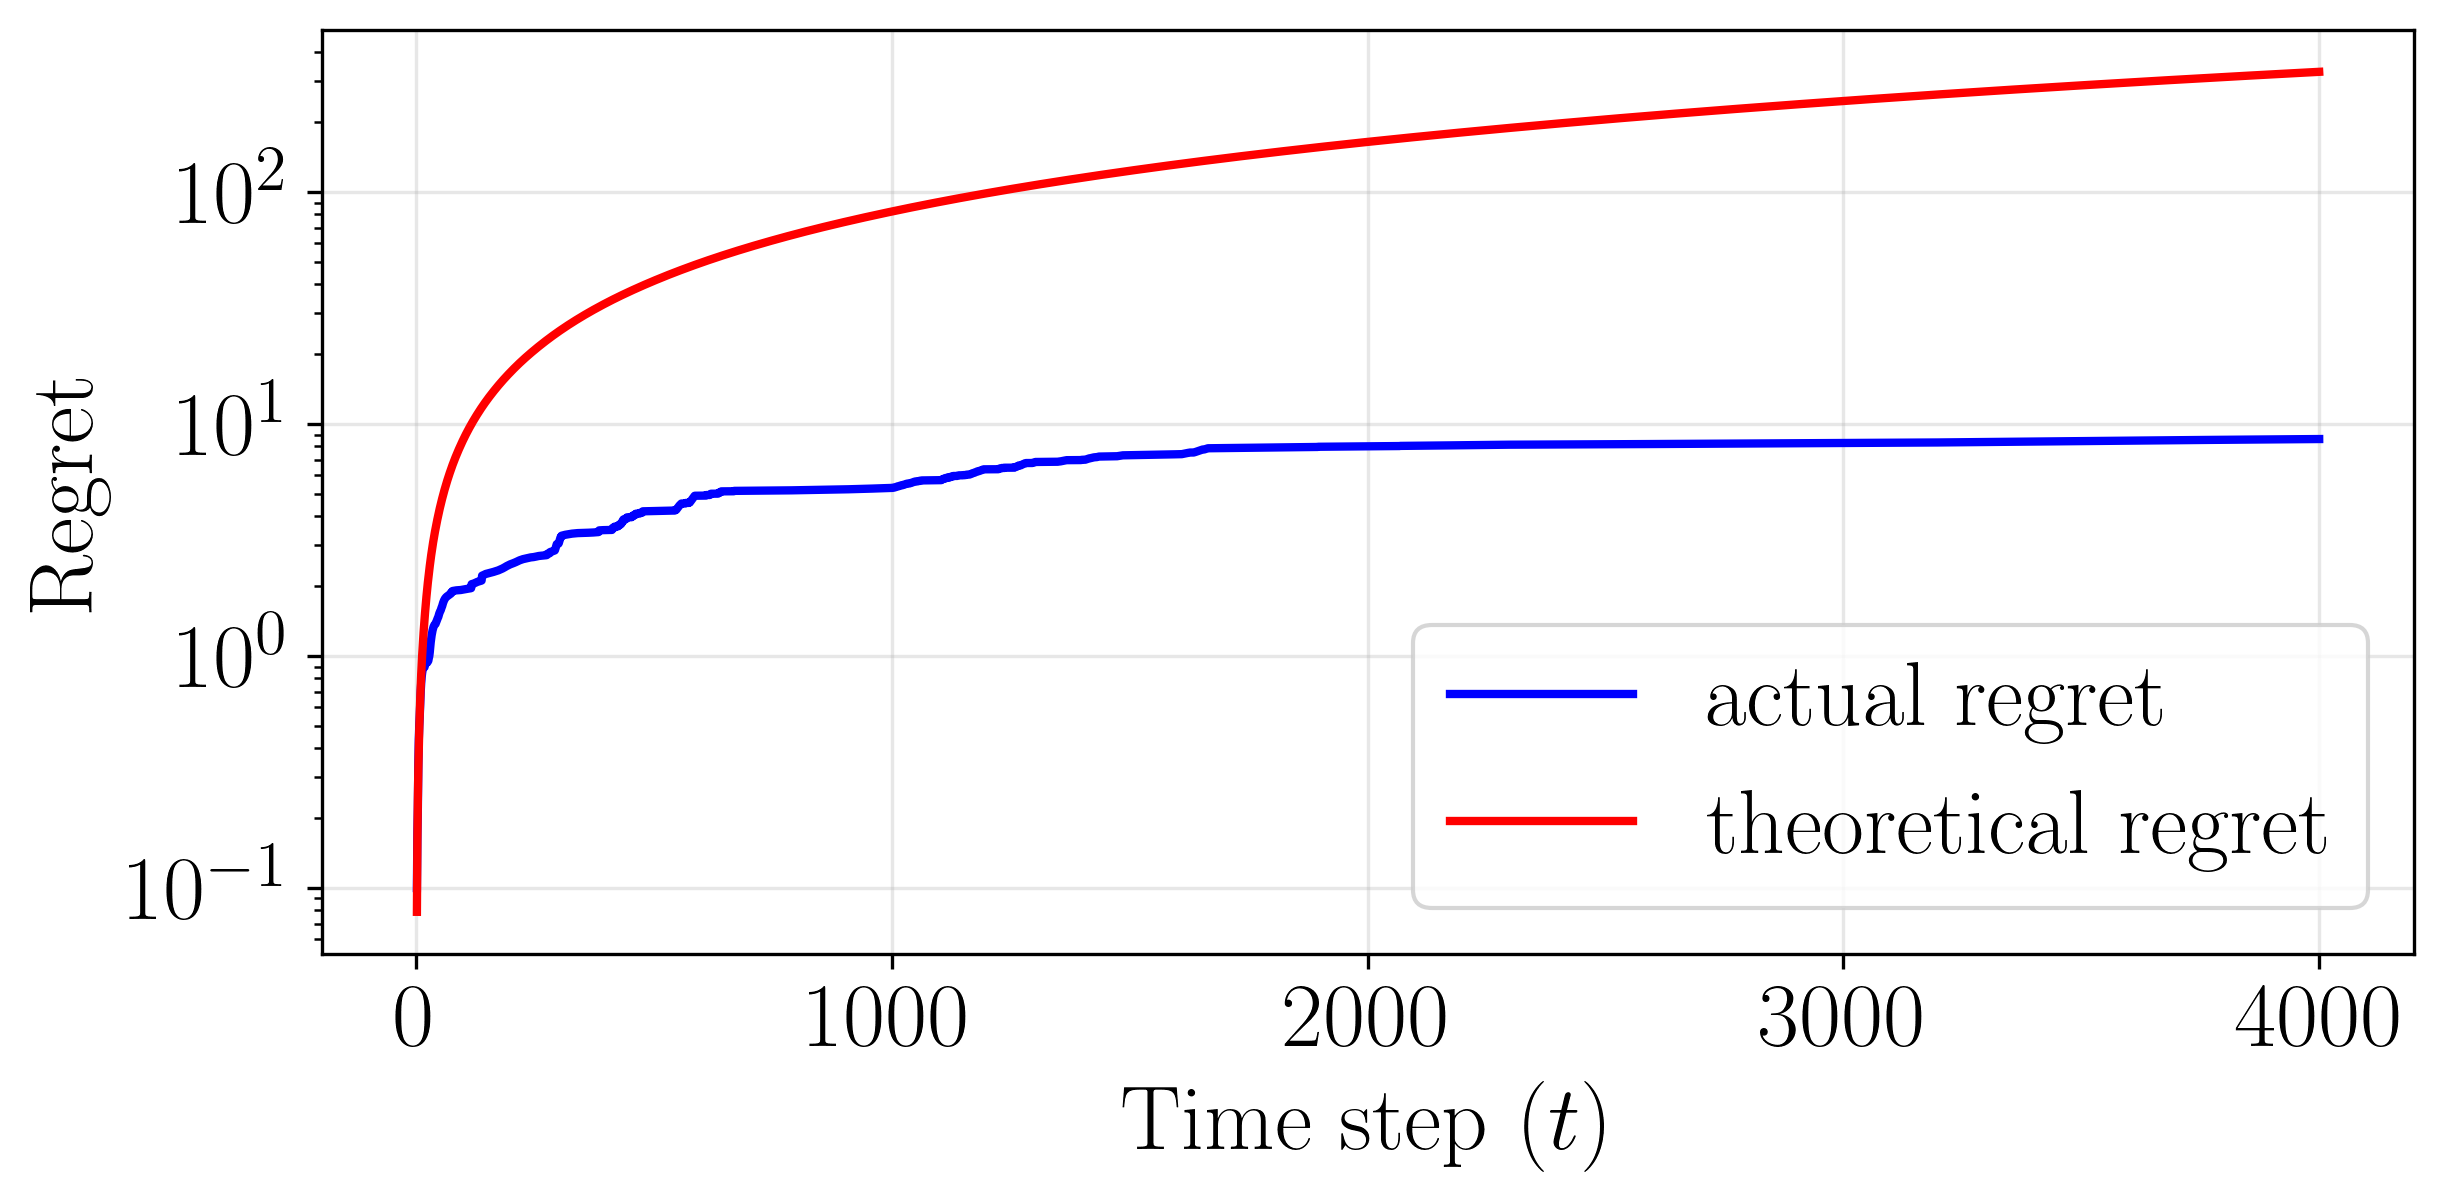

In [164]:
plot_regret_analysis(
        cum_regret, 
        None, 0.2*np.cumsum(avg)
    )

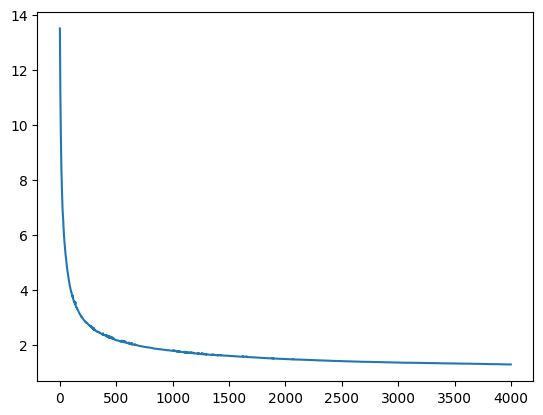

In [12]:
recluster_obj = np.load("recluster_obj.npy")
dro_obj = np.load("dro_obj.npy")
recluster_worst = np.load("recluster_worst.npy")
min_dist = np.load("min_dist.npy")
# plt.plot(np.array(recluster_obj))
# plt.plot(np.cumsum(inst_regret)/np.arange(1,4001))
# plt.hlines(xmin=0, xmax=4000, y=5*0.707)
# # plt.plot((5*0.7)*np.cumsum(min_dist[:4000])/np.arange(1,4001))
# plt.yscale("log")
# plt.plot(np.array(dro_obj))
# plt.plot(recluster_worst-dro_obj)
# plt.plot(np.cumsum(recluster_worst-dro_obj)/np.arange(1,4001))
# plt.hlines(xmin=0, xmax=100, y=5*0.71)
# plt.plot(np.diff(recluster_worst))
# plt.plot(np.diff(dro_obj))
# plt.plot(np.diff(recluster_worst) -np.diff(dro_obj) + (recluster_worst-dro_obj)[:-1])
# plt.plot(recluster_worst-dro_obj)
plt.plot(recluster_worst)

# plt.yscale("log")

In [25]:
-np.diff(recluster_worst) +np.diff(dro_obj) + (recluster_worst-dro_obj)[:-1]

array([ 0.1270796 ,  0.0953097 , -0.02159432, ...,  0.00026103,
        0.00030042,  0.00029226])

In [27]:
(recluster_worst-dro_obj)[0]

0.09984825769808658

In [49]:
recluster_worst[1] - recluster_worst[0] - (dro_obj[1] - dro_obj[0])

-0.02723134618287837

In [50]:
-np.diff(recluster_worst)[0] + np.diff(dro_obj)[0]

0.02723134618287837

In [40]:
(recluster_worst-dro_obj)[0]

0.09984825769808658

In [46]:
-np.diff(recluster_worst)[0] + np.diff(dro_obj)[0]

0.02723134618287837

In [28]:
recluster_worst[1] - recluster_worst[0]

-0.755837296791043

In [30]:
dro_obj[1] - dro_obj[0]

-0.7286059506081646

In [26]:
recluster_worst-dro_obj

array([0.09984826, 0.07261691, 0.04992413, ..., 0.00029473, 0.00028903,
       0.00028581])

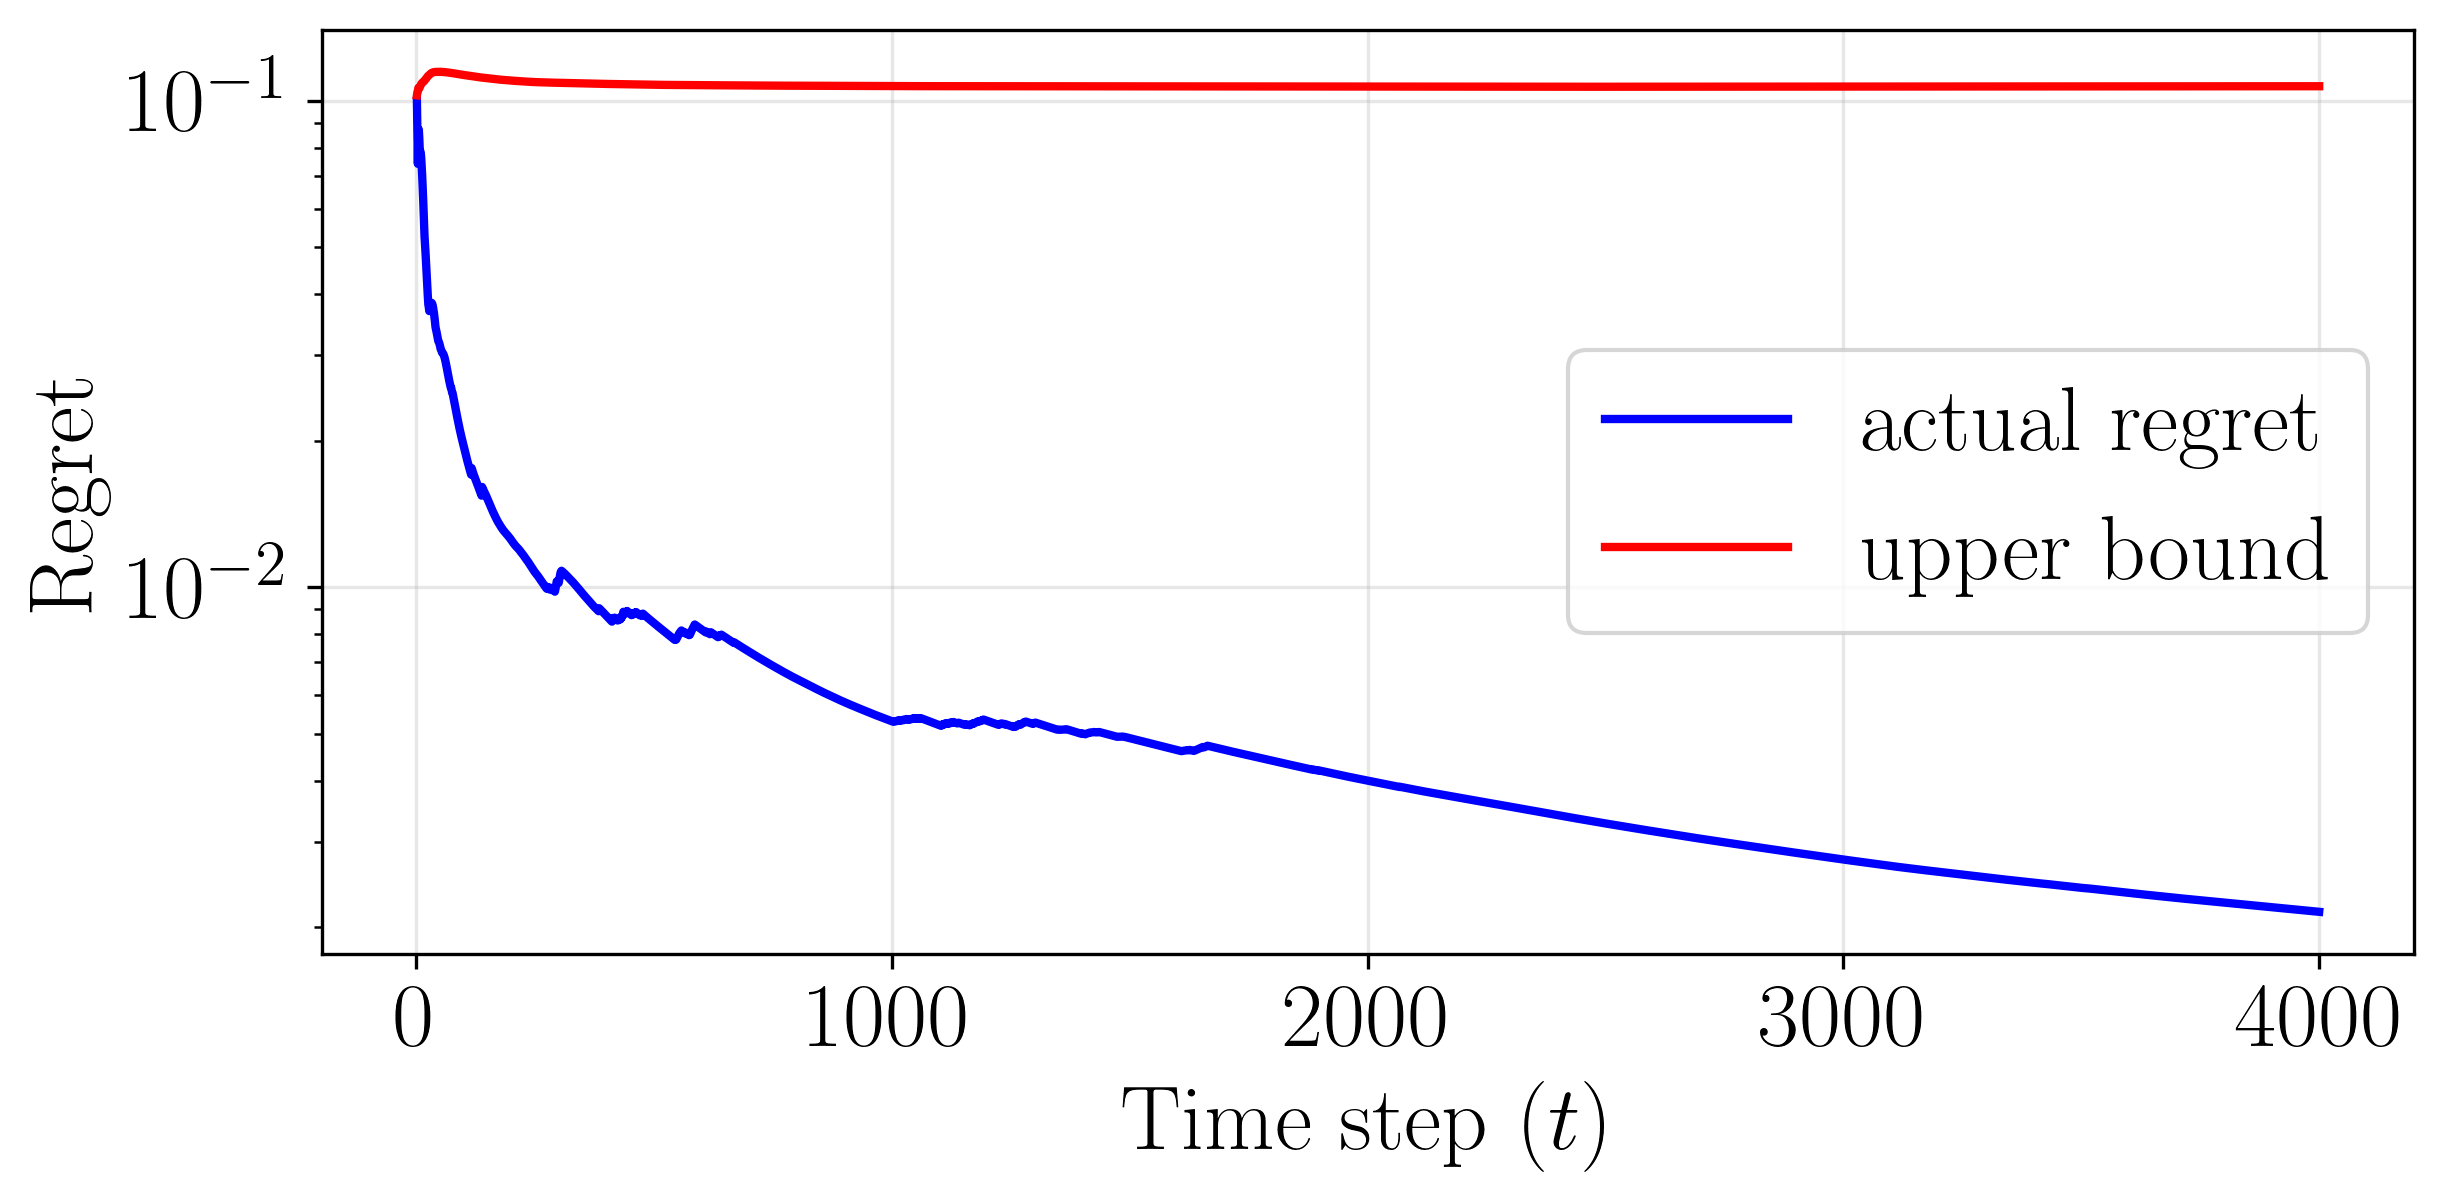

In [284]:
plot_regret_analysis(
        avg_regret, 
        None, 0.26*np.array(avg_mean)
    )

In [173]:
def createproblem_portMIP(N, m):
    """Create the problem in cvxpy, minimize CVaR
    Parameters
    ----------
    N: int
        Number of data samples
    m: int
        Size of each data sample
    Returns
    -------
    The instance and parameters of the cvxpy problem
    """
    # PARAMETERS #
    dat = cp.Parameter((N, m))
    eps = cp.Parameter()
    w = cp.Parameter(N)
    a = -5

    # VARIABLES #
    # weights, s_i, lambda, tau
    x = cp.Variable(m)
    s = cp.Variable(N)
    lam = cp.Variable()
    z = cp.Variable(m, boolean=True)
    tau = cp.Variable()
    # OBJECTIVE #
    objective = tau + eps*lam + w@s
    # + cp.quad_over_lin(a*x, 4*lam)
    # CONSTRAINTS #
    constraints = []
    constraints += [a*tau + a*dat@x <= s]
    constraints += [s >= 0]
    constraints += [cp.norm(a*x, 2) <= lam]
    constraints += [cp.sum(x) == 1]
    constraints += [x >= 0, x <= 1]
    constraints += [lam >= 0]
    constraints += [x - z <= 0, cp.sum(z) <= 10]
    # PROBLEM #
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, x, s, tau, lam, dat, eps, w

In [242]:
N = 1000
data = np.random.normal(0,0.1,(N,5))

In [250]:
DRO_problem, DRO_x, DRO_s, DRO_tau, DRO_lmbda, DRO_data, DRO_eps, DRO_w = createproblem_portMIP(N,5)
DRO_data.value = data
DRO_w.value = (1/N)*np.ones(N)
DRO_eps.value = 0.1
DRO_problem.solve(ignore_dpp=True, solver=cp.MOSEK, verbose=False, mosek_params={
    mosek.dparam.optimizer_max_time:  1500.0})
dro_obj = DRO_problem.objective.value

/Users/irina.wang/Desktop/Princeton/Project2/cvxpy/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


In [251]:
kmeans = KMeans(n_clusters=10).fit(data)
new_centers = kmeans.cluster_centers_
wk = np.bincount(kmeans.labels_) / N
online_problem, online_x, online_s, online_tau, online_lmbda, data_train, eps_train, w_train = createproblem_portMIP(10, 5)
data_train.value = new_centers
eps_train.value = 0.1
w_train.value = wk
online_problem.solve(ignore_dpp=True, solver=cp.MOSEK, verbose=False, mosek_params={
    mosek.dparam.optimizer_max_time:  1500.0})
mro_obj = online_problem.objective.value

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/irina.wang/Desktop/Princeton/Project2/cvxpy/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


In [252]:
orig_cons = DRO_problem.constraints
orig_obj = DRO_problem.objective
new_cons = orig_cons + [DRO_x == online_x.value, DRO_tau == online_tau.value]
new_problem = cp.Problem(orig_obj, new_cons)
new_problem.solve(ignore_dpp=True, solver=cp.MOSEK, verbose=False, mosek_params={mosek.dparam.optimizer_max_time:  1500.0})
mro_worst = new_problem.objective.value

/Users/irina.wang/Desktop/Princeton/Project2/cvxpy/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


In [253]:
noncenters = []
for i in data:
  if i not in new_centers:
      noncenters.append(np.min(cdist(np.reshape(i,(1,5)),new_centers,metric='euclidean')))

In [254]:
np.max(noncenters)

0.3562203952034466

In [259]:
mro_worst - mro_obj

0.022557848662967117

In [258]:
online_x.value, DRO_x.value

(array([0.21929728, 0.19131733, 0.21910923, 0.17233814, 0.19793802]),
 array([0.21929728, 0.19131733, 0.21910923, 0.17233814, 0.19793802]))